In [ ]:
# Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

In [ ]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
# !pip install joblib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV and Perform Basic Data Cleaning

In [2]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [3]:
# Keys to columns
# 4 fp flags (false positive flags)
# koi_period (orbital period in days)
# koi_time0bk (transit epoch)
# koi_impact (impact parameter)
# koi_duration (transit duration in hours)
# koi_depth (transit depth in ppm)
# koi_prad (planetary radius in Earth radii)
# koi_teq (equilibrium temperature in Kelvins)
# koi_insol (insolation flux in Earth flux)
# koi_model_snr (transit signal-to-noise)
# koi_tce_plnt_num (TCE planet number)
# koi_steff (stellar effective temperature in Kelvins)
# koi_slogg (stellar surface gravity logarithm)
# koi_srad (stellar radius)
# ra (RA - decimal degrees)
# dec (Dec - decimal degrees)
# koi_kepmag (Kepler-band in mag)

# Select your features (columns)

In [4]:
# Set features. This will also be used as your x values.
selected_features = df[['koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration',
                       'koi_depth', 'koi_prad', 'koi_steff', 'koi_slogg', 'koi_srad']]

# Note: Do not select the error margins 
# Items of interest:
# koi_disposition (confirmed planet or not)
# koi_period (orbital period in days)
# koi_time0bk (transit epoch) - How does transit epoch differ from transit duration (below)? 
# koi_impact (impact parameter) - need more information.  What is this?  
# koi_duration (transit duration in hours)
# koi_depth (transit depth in ppm)
# koi_prad (planetary radius in Earth radii) - Hypothesis:  Smaller objects may be asteroids, not planets.
# koi_steff (stellar effective temperature in Kelvins)
# koi_slogg (stellar surface gravity logarithm) - Hypothesis:  Stronger surface gravity of stars may keep objects in orbit - may indicate planethood.
# koi_srad (stellar radius) - Hypothesis:  Smaller stars may be less likely to have planets. 

selected_features = selected_features.rename(columns = {
    'koi_disposition': "Planetary Status", 
    'koi_period': "Orbit period (d)", 
    'koi_time0bk': "Transit epoch", 
    'koi_duration': "Transit duration (h)",
    'koi_depth': "Transit depth", 
    "koi_prad": "Planet radius",
    'koi_steff': "Stellar temp (K)", 
    'koi_slogg': "Stellar gravity", 
    'koi_srad': "Stellar radius"
})

selected_features

,Planetary Status,Orbit period (d),Transit epoch,Transit duration (h),Transit depth,Planet radius,Stellar temp (K),Stellar gravity,Stellar radius
0,CONFIRMED,54.418383,162.513840,4.50700,874.8,2.83,5455,4.467,0.927
1,FALSE POSITIVE,19.899140,175.850252,1.78220,10829.0,14.60,5853,4.544,0.868
2,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,33.46,5805,4.564,0.791
3,CONFIRMED,2.525592,171.595550,1.65450,603.3,2.75,6031,4.438,1.046
4,CONFIRMED,4.134435,172.979370,3.14020,686.0,2.77,6046,4.486,0.972
...,...,...,...,...,...,...,...,...,...
6986,FALSE POSITIVE,8.589871,132.016100,4.80600,87.7,1.11,5638,4.296,1.088
6987,FALSE POSITIVE,0.527699,131.705093,3.22210,1579.2,29.35,5638,4.529,0.903
6988,CANDIDATE,1.739849,133.001270,3.11400,48.5,0.72,6119,4.444,1.031
6989,FALSE POSITIVE,0.681402,132.181750,0.86500,103.6,1.07,6173,4.447,1.041


In [5]:
# Remove rows where "Planetary Status" is CANDIDATE
selected_features = selected_features.loc[selected_features["Planetary Status"] != "CANDIDATE"]

In [6]:
confirmed = selected_features.groupby("Planetary Status")
confirmed["Orbit period (d)"].count()

Planetary Status
CONFIRMED         1800
FALSE POSITIVE    3504
Name: Orbit period (d), dtype: int64

In [7]:
# Convert "Planetary Status" column to integer
selected_features = selected_features.replace({"CONFIRMED": int(1),
                                               "FALSE POSITIVE": int(-1)})

selected_features["Planetary Status"] = selected_features["Planetary Status"].astype("int64")

In [8]:
print("max radius = ", selected_features["Planet radius"].max())
print("min radius = ", selected_features["Planet radius"].min())
print("median radius = ", selected_features["Planet radius"].median())

max radius =  200346.0
min radius =  0.14
median radius =  2.74


In [9]:
# Drop rows with extremely large planetary radii
selected_features = selected_features.loc[selected_features["Planet radius"] <=10000]
# selected_features.sort_values(by=["Planet radius"])

,Planetary Status,Orbit period (d),Transit epoch,Transit duration (h),Transit depth,Planet radius,Stellar temp (K),Stellar gravity,Stellar radius
3246,-1,1.261328,132.427400,1.2440,109.7,0.14,2900,5.224,0.132
6554,-1,0.933749,131.526000,4.6370,226.2,0.18,2661,5.283,0.116
1902,-1,1.853739,132.668850,1.8160,348.6,0.23,2661,5.283,0.116
5597,-1,0.566787,131.849000,3.0740,7.5,0.27,6045,4.375,0.999
5432,-1,0.995196,132.471200,2.2930,13.7,0.29,5506,4.512,0.782
...,...,...,...,...,...,...,...,...,...
5175,-1,111.655460,148.893900,1.0510,2887.0,2121.00,6967,4.086,1.863
3491,-1,14.541781,144.269401,9.1151,143640.0,2722.92,5997,4.304,1.148
4336,-1,168.771180,233.313800,2.2630,2045.0,2825.04,4936,4.597,0.719
6535,-1,2.183518,132.692938,4.2703,1321.6,4633.66,3198,0.047,162.725


# Create a Train Test Split

Use `koi_disposition` for the y values

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [22]:
target = selected_features["Planetary Status"]
target_names = ["CONFIRMED", "FALSE POSITIVE"]

0    1
1   -1
2   -1
3    1
4    1
Name: Planetary Status, dtype: int64

In [23]:
X = selected_features[["Orbit period (d)", "Transit epoch", "Transit duration (h)",
                            "Planet radius", "Stellar temp (K)", "Stellar gravity", "Stellar radius"]]
# "Stellar temp (K)",
feature_names = X.columns

,Orbit period (d),Transit epoch,Transit duration (h),Planet radius,Stellar temp (K),Stellar gravity,Stellar radius
3246,1.261328,132.427400,1.2440,0.14,2900,5.224,0.132
6554,0.933749,131.526000,4.6370,0.18,2661,5.283,0.116
1902,1.853739,132.668850,1.8160,0.23,2661,5.283,0.116
5597,0.566787,131.849000,3.0740,0.27,6045,4.375,0.999
5432,0.995196,132.471200,2.2930,0.29,5506,4.512,0.782
...,...,...,...,...,...,...,...
5175,111.655460,148.893900,1.0510,2121.00,6967,4.086,1.863
3491,14.541781,144.269401,9.1151,2722.92,5997,4.304,1.148
4336,168.771180,233.313800,2.2630,2825.04,4936,4.597,0.719
6535,2.183518,132.692938,4.2703,4633.66,3198,0.047,162.725


In [24]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=42)

In [25]:
# Reshape the y values
y_train.shape
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(3970, 1)
(1324, 1)


(3970, 7)

# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [26]:
# Scale your data
X_minmax = MinMaxScaler(feature_range=(0, 10)).fit(X_train)
y_minmax = MinMaxScaler(feature_range=(0, 10)).fit(y_train)

X_train_scaled = X_minmax.transform(X_train)
X_test_scaled = X_minmax.transform(X_test)
y_train_scaled = y_minmax.transform(y_train)
y_test_scaled = y_minmax.transform(y_test)

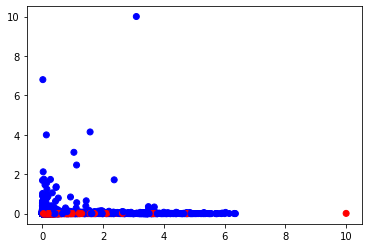

In [29]:
# Plot and show scatter
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 3], c=y_train_scaled, cmap="bwr");
plt.show()

# Train the Model



In [30]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train_scaled)

SVC(kernel='linear')

In [31]:
print(f"Training Data Score: {model.score(X_train_scaled, y_train_scaled)}")
print(f"Testing Data Score: {model.score(X_test_scaled, y_test_scaled)}")

Training Data Score: 0.6939546599496221
Testing Data Score: 0.676737160120846


In [32]:
# Calculate classification report
from sklearn.metrics import classification_report
predictions = model.predict(X_test_scaled)
print(classification_report(y_test_scaled, predictions,
                            target_names=target_names))

                precision    recall  f1-score   support

     CONFIRMED       0.68      0.93      0.79       860
FALSE POSITIVE       0.62      0.21      0.31       464

      accuracy                           0.68      1324
     macro avg       0.65      0.57      0.55      1324
  weighted avg       0.66      0.68      0.62      1324



# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [34]:
# Create the GridSearchCV model
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC 
from sklearn import set_config
set_config(display="diagram")

pipe = make_pipeline(model)
pipe

Pipeline(steps=[('svc', SVC(kernel='linear'))])

In [35]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(pipe, param_grid, verbose=3)

In [37]:
# Train the model with GridSearch
# Fit the model using the grid search estimator. 
# This will take the SVC model and try each combination of parameters
grid.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] svc__C=1, svc__gamma=0.0001 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0001, score=0.696, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0001 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ......... svc__C=1, svc__gamma=0.0001, score=0.699, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0001 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0001, score=0.684, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0001 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ......... svc__C=1, svc__gamma=0.0001, score=0.694, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0001 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0001, score=0.686, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0005 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0005, score=0.696, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0005 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0005, score=0.699, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0005 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0005, score=0.684, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0005 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0005, score=0.694, total=   0.2s
[CV] svc__C=1, svc__gamma=0.0005 .....................................
[CV] ......... svc__C=1, svc__gamma=0.0005, score=0.686, total=   0.2s
[CV] svc__C=1, svc__gamma=0.001 ......................................
[CV] .

[CV] ........ svc__C=50, svc__gamma=0.0001, score=0.775, total=   0.8s
[CV] svc__C=50, svc__gamma=0.0001 ....................................
[CV] ........ svc__C=50, svc__gamma=0.0001, score=0.741, total=   0.9s
[CV] svc__C=50, svc__gamma=0.0001 ....................................
[CV] ........ svc__C=50, svc__gamma=0.0001, score=0.771, total=   0.8s
[CV] svc__C=50, svc__gamma=0.0001 ....................................
[CV] ........ svc__C=50, svc__gamma=0.0001, score=0.758, total=   0.8s
[CV] svc__C=50, svc__gamma=0.0005 ....................................
[CV] ........ svc__C=50, svc__gamma=0.0005, score=0.752, total=   0.9s
[CV] svc__C=50, svc__gamma=0.0005 ....................................
[CV] ........ svc__C=50, svc__gamma=0.0005, score=0.775, total=   0.9s
[CV] svc__C=50, svc__gamma=0.0005 ....................................
[CV] ........ svc__C=50, svc__gamma=0.0005, score=0.741, total=   0.9s
[CV] svc__C=50, svc__gamma=0.0005 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   32.5s finished


GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
             verbose=3)

In [39]:
print(grid.best_params_)
print(grid.best_score_)

{'svc__C': 50, 'svc__gamma': 0.0001}
0.7591939546599497


In [45]:
# Make predictions with the hypertuned model
predictions = grid.predict(X_test_scaled)

# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_scaled, predictions, target_names=target_names))

                precision    recall  f1-score   support

     CONFIRMED       0.84      0.75      0.79       860
FALSE POSITIVE       0.61      0.73      0.66       464

      accuracy                           0.74      1324
     macro avg       0.72      0.74      0.73      1324
  weighted avg       0.76      0.74      0.75      1324



# Save the Model

In [46]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = 'Robert_Ottogalli_SVM.sav'
joblib.dump(grid, filename)

['Robert_Ottogalli_SVM.sav']